# Problem Statement:
In the Traveling Salesman Problem (TSP), we have a set of cities, and the distances between each pair of cities are known. The problem is to find the shortest possible route that visits each city exactly once and returns to the starting city (often referred to as the depot).

---
### TSP formulation: 

N = # number of cities to visit ( 0 represents depot )

I = set of cities = {0,...,N}

K = set of cities excluding depot = {1,...,N}

$v_{i} = $ each city i visited in order excluding depot.

$d_{ij} = $ distance between city i to city j.

$X_{ij} $ $ = 1 $ if city j is visited from city i.

---
### Model

MIN $ Z = \sum_{i=0}^n \sum_{j=0}^n {d_{ij} * X_{ij}}$

subject to:
    
1)  reach every city from exactly one predecessor

    $\sum_{i=0}^n {X_{ij}} = 1 $ $\forall j$ $\in$ I

2)  leave every city to exactly one succesor

    $\sum_{j=0}^n {X_{ij}} = 1 $ $\forall i$ $\in$ I

3) subtour elimination

    $ (N - 1)*(1 - X_{ij}) $ $ \geq $ $ v_{i}  - v_{j} + 1  $   $\forall i, j$ $\in$ K

4) variable types: x as binary, v as integer

    $ X_{ij} $ $\in$ {0,1} ,  $ v_{i} $ $\in$ { 0, ... , N - 1 }

    

--- 24.299497842788696 PARS model run time in seconds ---
Objective Function:  7293.0
Best trajectory found:
0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0


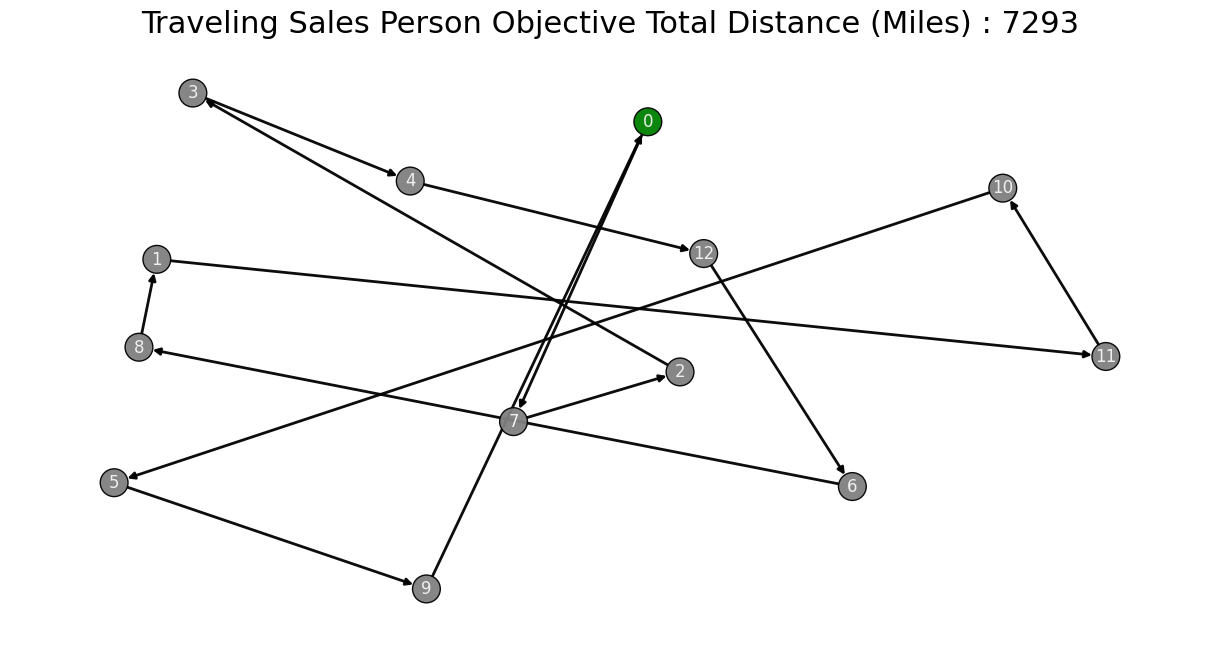

In [1]:
import pandas as pd
from ortools.linear_solver import pywraplp
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import networkx as nx

#distance matrix of cities, row are from, cols are to, value of row and col is distance from row to col city
distance_matrix = pd.DataFrame([
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
])

def tsp_network_viz(x:str, distance_matrix:pd.DataFrame, figsize=(12,6), seed=33):
    '''TSP network visual'''

    # networkx graph format
    G = nx.from_numpy_array(A = distance_matrix.to_numpy())
    G = nx.DiGraph(G, name='Traveling Sales Person Route')
    pos = nx.spring_layout(G, seed=seed)

    # define order of visited cities and store total distance
    route , total_distance = [] , []
    for i in range(len(x)):
        if i < len(x)-1:
            total_distance.append(distance_matrix.iloc[x[i], x[i+1]])
            route.append( (x[i] , x[i+1]) )

    # figure size
    plt.figure(figsize=figsize) 

    # visual format
    node_colors = ['green' if i==0 else "grey" for i in distance_matrix.index]
    options = {"edgecolors": "black", "node_size": 400, "alpha": 0.95, "edge_color":"black", "font_color":"whitesmoke"}

    # route visual
    nx.draw(G = G, pos = pos ,with_labels=True, node_color = node_colors, edgelist = route,  arrowstyle='-|>', width= 2 ,**options)
    plt.title(f'Traveling Sales Person Objective Total Distance (Miles) : {str(sum(total_distance))}',loc = 'center', fontsize = 22);

def tsp_math_model(d_ij:pd.DataFrame):
    """
    Returns route with min total distance considering round trip. (TSP math model)
    """
    # method run time
    start_time = time.time()

    # number of cities
    N = len(d_ij)

    # set of cities
    I = [*range(0,N)]

    # set of cities excluding depot
    K = [*range(1,N)]

    # Solver
    solver = pywraplp.Solver("TSP",pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # Variable: t[i] indicates the sequential order of visit and takes values from 1 to N - 1
    v = {}
    for i in K:
        v[i] = solver.IntVar(1, N-1, 't[%i]'%(i))

    # Variable: x[i, j] as binary 0 or 1
    x = {}
    for i in I:
        for j in I:
            x[i, j] = solver.BoolVar('x[%i,%i]'%(i,j))

    # Objective: min total distance traveled
    solver.Minimize(solver.Sum([d_ij.iloc[i,j]*x[i, j] for i in I for j in I]))

    # Constraint 1: exactly one predecessor
    for j in I:
        solver.Add(solver.Sum([x[i, j] for i in I]) == 1)


    # Constraint 2: exactly one successor
    for i in I:
        solver.Add(solver.Sum([x[i, j] for j in I]) == 1)

    # Constraint 3 : Subtour elimination
    for i in K:
        for j in K:
            solver.Add( v[i] - v[j] + 1  <= (N - 1)*(1-x[i,j]))

    # Print solution
    sol = solver.Solve()
    from_, to_ = [], []
    if sol == pywraplp.Solver.OPTIMAL:
        z = solver.Objective().Value()
        for i in range(N):
            for j in range(N):
                if x[i,j].solution_value() > 0:
                    from_.append(i)
                    to_.append(j)

    # Create a mapping dictionary
    mapping = dict(zip(from_, to_ ))

    # Start with the first key
    current_key = from_[0]
    sequence = [current_key]

    # Traverse through the mapping
    for _ in range(len(mapping)):
        current_value = mapping[current_key]
        sequence.append(current_value)
        current_key = current_value

    # Convert the sequence to the desired format
    formatted_output = ' -> '.join(map(str, sequence))

    # print run time
    print("--- %s PARS model run time in seconds ---" % (time.time() - start_time))
    print('Objective Function: ', z)
    print('Best trajectory found:')
    print(formatted_output)

    return sequence

# Driver code
sequence = tsp_math_model(d_ij = distance_matrix)

# visual 
tsp_network_viz(x = sequence,
                distance_matrix = distance_matrix)

# Q-learning in Reinforcement Learning

## Introduction

Q-learning is a model-free reinforcement learning algorithm used to find the optimal action-selection policy for a given finite Markov decision process. In simpler terms, it's an algorithm that helps an agent (like a robot or drone) learn how to choose optimal actions that yield the most reward over time.

---

## Q-function

The central component of the Q-learning algorithm is the Q-function. It's denoted as $Q(s, a)$ and represents the expected reward of taking action $a$ in state $s$.

The Q-function is updated using the Bellman equation:

\begin{equation}
Q(s, a) = r + \gamma \max_{a'} Q(s', a')
\end{equation}

Where:

- $r$ is the reward received after taking action $a$ in state $s$.
- $\gamma$ is the discount factor, which models the agent's consideration for future rewards. A high value (close to 1) makes the agent prioritize long-term reward over short-term reward.
- $s'$ is the next state.
- $a'$ is any possible action in state $s'$.

---
## Algorithm

1. Initialize Q-values arbitrarily for all state-action pairs.
2. For each episode:
    1. Start at a random state.
    2. For each step in the episode:
        1. Choose an action $a$ from state $s$ using a policy derived from the current Q (e.g., $\epsilon - greedy$).
        2. Take the action, and observe the reward $r$ and the new state $s'$.
        3. Update the Q-value using the Bellman equation.
        4. Set $s = s'$.
    3. Repeat until a terminal state is reached.

---
## Exploration vs. Exploitation

A significant challenge in Q-learning is the trade-off between exploration (trying new actions) and exploitation (relying on known information). A common solution is the $\epsilon - greedy$ policy:

- With probability $\epsilon$, choose a random action.
- With probability $1 - \epsilon$, choose the action with the highest Q-value.

Over time, $\epsilon$ is decreased so that the agent explores less and exploits more.


--- 4.678481817245483 PARS model run time in seconds ---
Objective Function:  7670
Best trajectory found:
0 -> 2 -> 9 -> 5 -> 10 -> 4 -> 12 -> 11 -> 1 -> 8 -> 6 -> 3 -> 7 -> 0


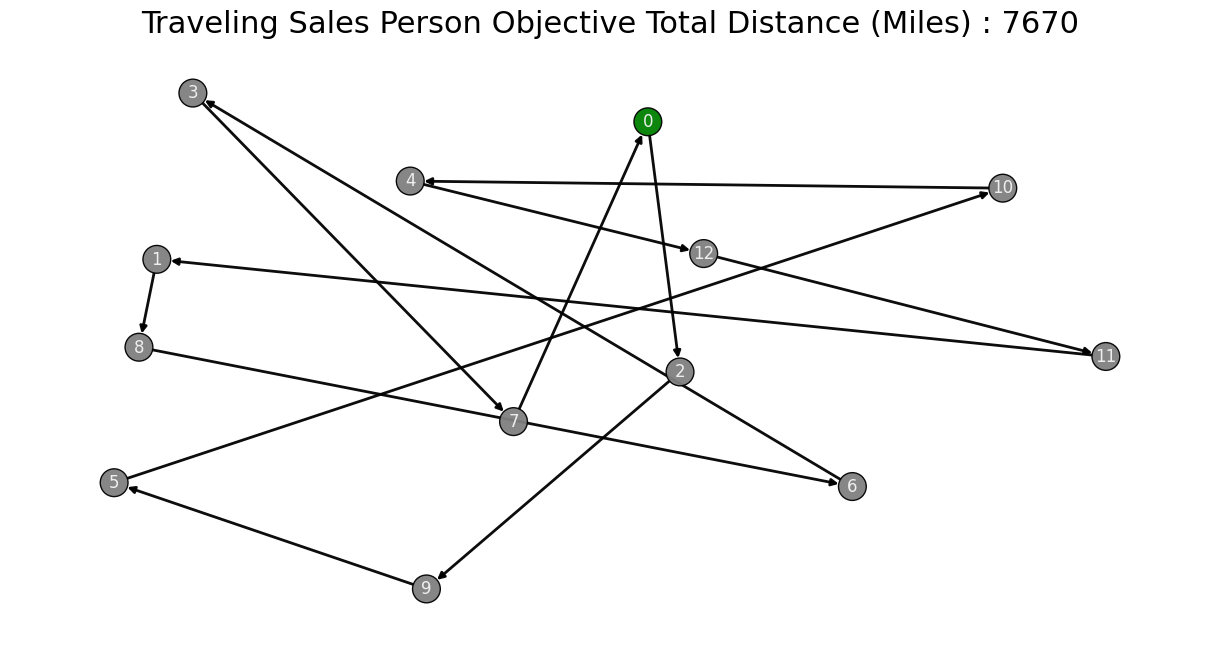

In [2]:
def update_q(q, distance_matrix, state, action, alpha, gamma):
    ''' Updates Q table for reinforcement learning'''

    # reward for current stage and action
    reward =  1/distance_matrix.loc[state,action]

    # max reward for next stage and activity value
    delayed_reward = q[action,:].max()

    # update q value
    q[state,action] = q[state,action] + alpha * (reward + gamma * delayed_reward -  q[state,action])

    return q
    
def encoding(string:str, distance_matrix:pd.DataFrame):
    ''' Return objective function for vehicle routing problem given a string of sequences where the delimeter | indicates a new vehicle'''
    initial_city = 0
    # get cities in sequence
    l = [ int(x) for x in string.split('-') ] 
    l.insert(0,initial_city)
    l.insert(len(l),initial_city)

    # get distance traveled
    total_distance = []
    for i in range(len(l)):
        if i < len(l)-1:
            total_distance.append(distance_matrix.iloc[l[i], l[i+1]])

    # store total distances traveled by vehicle and total distance among all vehicles
    obj_val = sum(total_distance)

    return  obj_val

def q_learning(distance_matrix, exploration_proba, n_episodes, alpha, gamma):
    '''Main call for RL appied to TSP'''
    # method run time
    start_time = time.time()
    
    # initializing cities and q matrix
    cities = len(distance_matrix)
    q = np.zeros([cities,cities])

    # store values
    seqs, Z = {} , {}

    # exploration thresholds
    exploration_decreasing_decay , min_exploration_proba = 0.001 , 0.01

    # train model to learn from experience
    for e in range(n_episodes):
        # initial city as initial stat
        visited, state = [0] , 0

        # posible actions at initial state
        possible_actions = [ next_city for next_city in range(cities) if next_city not in visited]

        # iterate until all destinations are visited
        while possible_actions:
            if np.random.uniform(0,1) < exploration_proba:
                action = np.random.choice(possible_actions)
            else:       
                best_action_index = q[state, possible_actions].argmax()
                action = possible_actions[best_action_index]

            # update q table
            q = update_q(q, distance_matrix, state, action,alpha=alpha, gamma=gamma)
            visited.append(action)
            state = visited[-1]
            possible_actions = [ next_city for next_city in range(cities) if next_city not in visited]

        #We update the exploration proba using exponential decay formula 
        exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e)) 
        seqs[e] = '-'.join([str(y) for y in copy.copy(visited) if y!=0 ] ) #visited
        Z[e] = encoding(string = '-'.join([str(y) for y in copy.copy(visited) if y!=0 ] ),  distance_matrix = distance_matrix)
    
    # best sequence
    z,s = Z[min(Z, key=Z.get)], seqs[min(Z, key=Z.get)]
    
    # print run time & results
    print("--- %s PARS model run time in seconds ---" % (time.time() - start_time))
    print('Objective Function: ', z)
    print('Best trajectory found:')
    print(' -> '.join([ str(x) for x in (str(0)+'-'+s+'-'+str(0)).split('-') ] ))

    sequence = str(0) + '-' + s + '-' + str(0)
    return [int(i) for i in sequence.split('-')]

# Driver code      
sequence = q_learning(distance_matrix = distance_matrix,
                       exploration_proba = 0.5,
                       n_episodes = 2000,
                       alpha=0.5,
                       gamma=0.7)

# visual 
tsp_network_viz(x = sequence,
                distance_matrix = distance_matrix)

# Simulated Annealing for the Traveling Salesman Problem (TSP)

---
## Introduction

Simulated Annealing (SA) is a probabilistic optimization technique inspired by the annealing process in metallurgy. Annealing involves heating a material and then cooling it slowly. Simulated annealing applies this concept to find an approximation to the global optimum of a function.

The Traveling Salesman Problem (TSP) is a classic optimization problem where a salesman wishes to visit a number of cities exactly once and return to the starting city while minimizing the total distance traveled.

---
## The Simulated Annealing Algorithm for TSP

1. **Initialization**:
    - Start with an initial feasible solution (usually a random permutation of cities).
    - Set an initial temperature $T$ and a minimum temperature $T_{\text{min}}$.
    - Choose a cooling rate $\alpha$ (typically between 0.8 and 0.99).

2. **Iterative Process**:
    - While $T > T_{\text{min}}$:
        - For a number of iterations:
            - Generate a neighbor solution by making a small change to the current solution (e.g., swapping two randomly selected cities).
            - Calculate the difference in the cost (distance) between the new solution and the current solution: $\Delta E$.
            - If the new solution is better or if a random number between 0 and 1 is less than $e^{-\Delta E/T}$, accept the new solution as the current solution.
        - Decrease the temperature: $T = \alpha \times T$.

3. **Termination**:
    - When the temperature is less than $T_{\text{min}}$, the algorithm terminates, and the best-found solution is returned.

---
## Key Concepts:
- **Temperature $T$**: It's a control parameter that determines the probability of accepting a worse solution than the current one. A high temperature increases the chance of accepting worse solutions, promoting exploration, while a low temperature tends to accept only better solutions, promoting exploitation.

- **Cooling Schedule**: How the temperature decreases over time. A typical method is geometric cooling, where the temperature is multiplied by a constant factor $\alpha$.

- **Neighbor Solution Generation**: In TSP, a neighbor can be generated by various methods such as swapping two cities, reversing a subsection of the tour, or other perturbations.



--- 4.590648889541626 PARS model run time in seconds ---
Objective Function:  7534
Best trajectory found:
0 -> 7 -> 2 -> 9 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 5 -> 10 -> 0


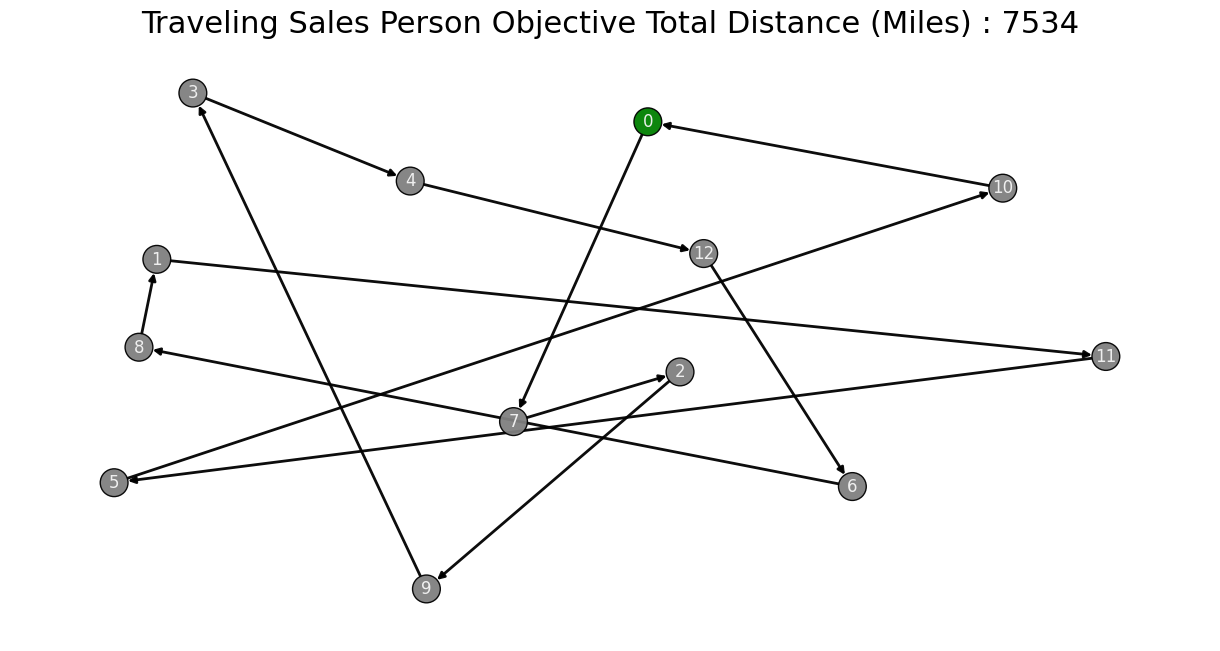

In [3]:
def nearest_neighbor_initial_sol(start:int,distance_matrix:pd.DataFrame):
    '''Generates an initial solution using nearest neighbor.'''

    # first city cisited
    visited = [distance_matrix.loc[start, distance_matrix.columns != start].idxmin()]
    not_visited = [*set([*distance_matrix.columns]) - set(visited) - set([start])]

    # get min distance to next city
    while len(not_visited) != 0:
        next_city = distance_matrix.loc[visited[-1], not_visited].idxmin()
        visited.append(next_city)
        not_visited.remove(next_city)
    encoded_string = '-'.join([ str(w) for w in copy.copy(visited)])

    return encoded_string

def decoding(string:str):
    ''' adds depot to sequence'''
    
    # route seqeunce
    sequences = {}
    sequences.update({0: str(0)+'-'+string+'-'+str(0)})

    return sequences
    
def encoding(string:str, distance_matrix:pd.DataFrame):
    ''' Return objective function for vehicle routing problem given a string of sequences where the delimeter | indicates a new vehicle'''

    initial_city = 0
    # get cities in sequence
    l = [ int(x) for x in string.split('-') ] 
    l.insert(0,initial_city)
    l.insert(len(l),initial_city)

    # get distance traveled
    total_distance = []
    for i in range(len(l)):
        if i < len(l)-1:
            total_distance.append(distance_matrix.iloc[l[i], l[i+1]])

    # store total distances traveled by vehicle and total distance among all vehicles
    obj_val = sum(total_distance)

    return  obj_val
    
def pair_wise(s):
    'Generates a new sequence using an inut string'

    # get sequence for vehicle
    k = [ int(y) for y in copy.copy(s.split('-')) ] 

    # change two random positions
    a = np.random.randint(low = 1, high = len(s.split('-')) - 1 ,size=1)[0]
    b = np.random.randint(low = 1, high = len(s.split('-')) - 1 ,size=1)[0]
    k[a], k[b] = k[b], k[a]

    # create new encoded sequence
    new_sequence = '-'.join([ str(y) for y in copy.copy(k) ] )
    
    return new_sequence

def simulated_annealing(inital_s:str, num_of_iters:int,  T_init:int , alpha:float , N:int, distance_matrix:pd.DataFrame):
    ''' main SA call'''
    # method run time
    start_time = time.time()

    # counter for while loop, list of all obj fun, list for strings of sols, sols sin mejorar en una temp, initial temp val, initial solution 
    i, Z, seqs, M, T, s = 1, {}, {}, 0, T_init, inital_s

    # encoding initial sol
    f_s = encoding(string = s,  distance_matrix = distance_matrix)

    # store initial sols
    seqs[0] = s
    Z[0] = f_s

    # iters of schedule
    while i < num_of_iters+1:

        # new sol
        s_new = pair_wise(s = s)
        f_s_new = encoding(string = s_new,  distance_matrix = distance_matrix)
        seqs[i] = s_new
        Z[i] = f_s_new

        # normal dist random nums
        threshold = np.random.uniform(0,1)

        # aceptance probability for new solution
        aceptance_prob = min(1, np.exp( (f_s - f_s_new) / T ) )

        # condition to reject or accept new solution
        if f_s_new <= f_s:
            s = s_new
            f_s = f_s_new
            M = 0
        else:
            if threshold < aceptance_prob:
                s = s_new
                f_s = f_s_new
                M = 0
            else:
                M += 1
                if M == N:
                    T = T*alpha
                    if T <= 0.1:
                        break
        i += 1
        
    # best sequence
    z, s = Z[min(Z, key=Z.get)], seqs[min(Z, key=Z.get)]

    # print run time & results
    print("--- %s PARS model run time in seconds ---" % (time.time() - start_time))
    print('Objective Function: ', z)
    print('Best trajectory found:')
    print(' -> '.join([ str(x) for x in (str(0)+'-'+s+'-'+str(0)).split('-') ] ))

    sequence = str(0)+'-'+s+'-'+str(0)
    return [int(i) for i in sequence.split('-')]

# simulated annealing call
inital_s = nearest_neighbor_initial_sol(start = 0, distance_matrix = distance_matrix)
sequence = simulated_annealing(inital_s = inital_s ,num_of_iters = 2000 , T_init = 250, alpha = 0.99, N = 250, distance_matrix=distance_matrix) 

# visual
tsp_network_viz(x = sequence,
                distance_matrix = distance_matrix)